In [205]:
import skimage as ski
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

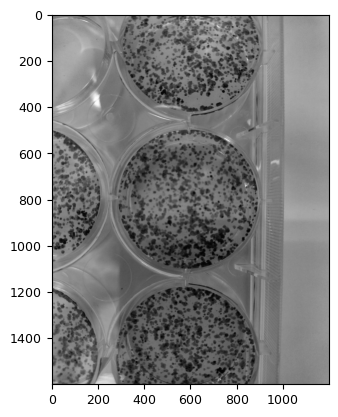

In [206]:
image = cv.imread("/home/frederico/Downloads/WhatsApp Image 2023-07-13 at 15.58.39.jpeg")
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.show()

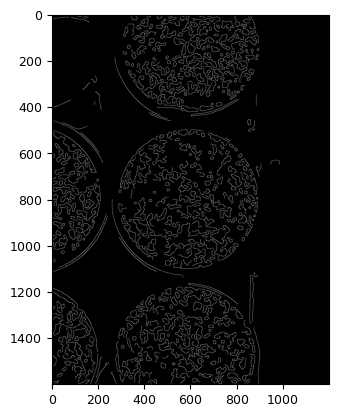

In [207]:
edges = ski.feature.canny(image_gray, sigma=3)
plt.imshow(edges, cmap="gray")
plt.show()

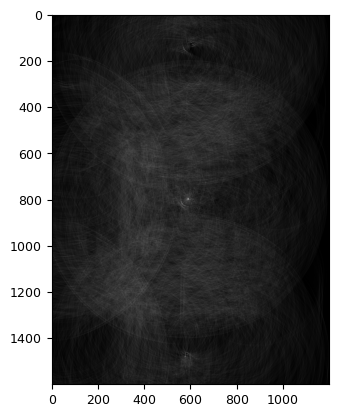

In [208]:
radius = [300]
hough_res = ski.transform.hough_circle(edges, radius)

plt.imshow(hough_res[0], cmap="gray")
plt.show()

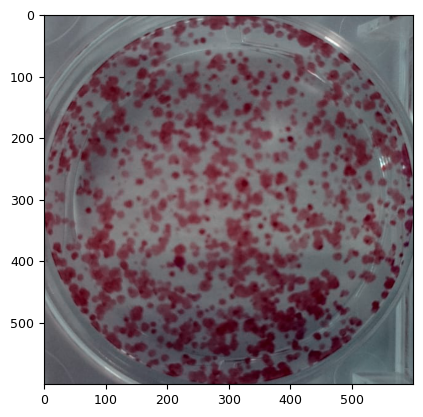

In [209]:
accum, cx, cy, radii = ski.transform.hough_circle_peaks(hough_res, radius, min_xdistance=radius[0], min_ydistance=radius[0])

x, y = image.shape[1], image.shape[0]

circles = [{"cx": x[0], "cy": x[1], "radii": x[2]} for x in zip(cx, cy, radii)]
circles = list(filter(lambda c: c["cx"] - c["radii"] > 0 and c["cx"] + c["radii"] < x and c["cy"] - c["radii"] > 0 and c["cy"] + c["radii"] < y, circles))

x_plots = 3 if len(circles) > 3 else len(circles)
y_plots = len(circles) // 3 + (1 if len(circles) % 3 > 0 else 0)

for circle in circles:
    plt.imshow(image[circle["cy"] - circle["radii"]:circle["cy"] + circle["radii"], circle["cx"] - circle["radii"]:circle["cx"] + circle["radii"]], cmap="gray")
plt.show()

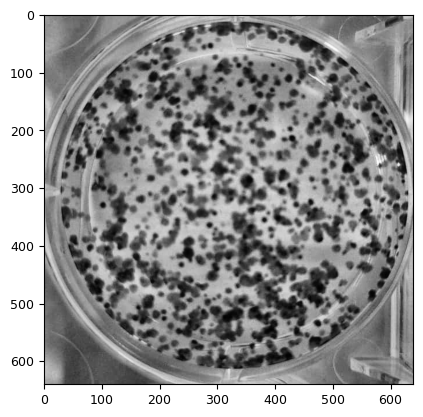

In [210]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
cl1 = clahe.apply(well_image[:, :,2])

plt.imshow(cl1, cmap="gray")
plt.show()

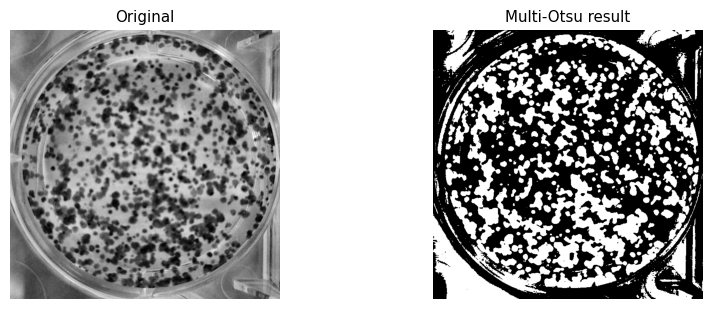

In [211]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cl1

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes = 2)

# Using the threshold values, we generate the three regions.
regions = cv.bitwise_not(np.digitize(image, bins=thresholds))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(regions, cmap='gray')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.subplots_adjust()

plt.show()

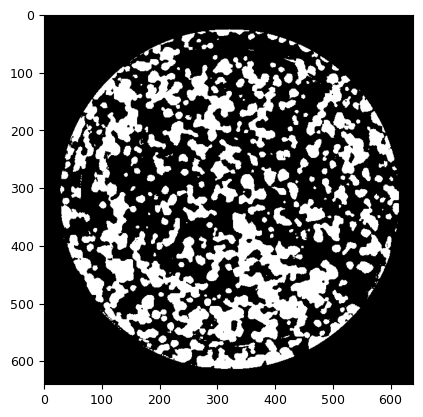

In [235]:
center = well_image.shape[0] // 2, well_image.shape[1] // 2

#paint black everythoing outside a circle inscribed in the image
mask = np.zeros(well_image.shape[:2], dtype="uint8")
cv.circle(mask, center, center[0] - round(0.08 * center[0]), (255, 255, 255), -1)
masked = cv.bitwise_and(regions, regions, mask=mask)

masked = masked == -1
masked = masked.astype("uint8")

plt.imshow(masked, cmap="gray")
plt.show()

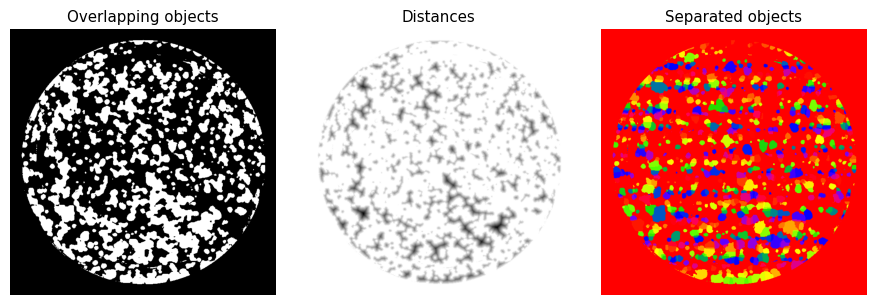

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
image = masked

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap="prism")
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

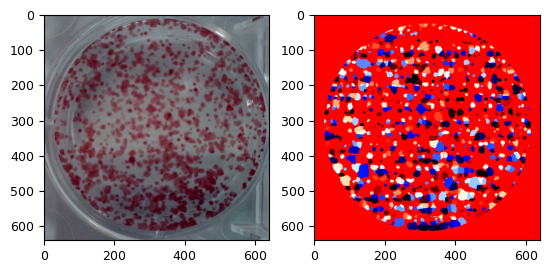

In [234]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(well_image)
ax[1].imshow(labels, cmap="flag")
plt.show()
